In [1]:
from src.tests import *
import cv2
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import time 

## Resources

This depth model architechture is from: https://arxiv.org/abs/1809.04766

We will make changes in the model but the APIs will remain same. All model related files will be in src folder.
For preprocessing, we all can use this notebook or we can add a python file additionally.

In [2]:
img_path = 'examples/ExpKITTI_joint/278_org.png'
img_org = np.array(Image.open(img_path))

depth_y_path = 'examples/ExpKITTI_joint/278_depth.png'
depth_y = np.array(Image.open(depth_y_path))

# processing orignal depth images
assert(np.max(depth_y) > 255)
depth_y = depth_y.astype(np.float) / 256.

## PCA

In [3]:
pca_img = img_org.reshape(375, -1 )
# Increasing n components will increance explained variance but will decrease our accuracy benefits.
pca = PCA(n_components = 64, svd_solver='randomized').fit(pca_img)
pca_img = pca.transform(pca_img)
print(pca_img.shape )
print("Retained variance", np.sum(pca.explained_variance_ratio_))
img = pca.inverse_transform(pca_img)
img = img.reshape(375, 1242, 3)

(375, 64)
Retained variance 0.9622597384383695


## Evaluation

In [4]:
def RMSE(target, prediction):
    return np.sqrt(np.mean((target - prediction)**2))

In [5]:
def measure_duration(img, times = 10):
    durations = []
    for _ in range(times):
        start = time.time()
        depth = run(img)
        end = time.time()
        durations.append(end - start)
    return depth, (sum(durations) / times)

In [7]:
depth_pca, duration_pca = measure_duration(img, 10)
depth_no_pca, duration_no_pca = measure_duration(img_org, 10)
diff = duration_no_pca - duration_pca
print("Run time diff ", round(diff, 4))

Run time diff  -0.0016


Imporved accuracy but no benefit in processing time :( 

In [8]:
rmse = RMSE(depth_y, depth_no_pca)
pca_rmse = RMSE(depth_y, depth_pca)
print('accuracy change %: ',(rmse - pca_rmse)*100/rmse )

accuracy change %:  19.899622033804242


## RMSE and time taken with frame skipping

In [9]:
def runDepthEstimator(start_frame=275, end_frame=300, num_iter=100, isFrameSkippingEnabled=True):
    prevPredDepth = depth_no_pca
    prevDepthExists = False
    runModel = True
    totalRmse = 0
    start = time.time()

    for img in range(start_frame,end_frame):
        imgPath = 'examples/kitti_car/0000000'+str(img)+'.png'
        depthPath = 'examples/kitti_car/depth/0000000'+str(img)+'.png'
        depth_y = np.array(Image.open(depthPath))

        # processing orignal depth images
        assert(np.max(depth_y) > 255)
        depth_y = depth_y.astype(np.float) / 256.
        
        #Run model everytime if frameSkipping is disabled
        if(not isFrameSkippingEnabled):
            runModel = True
            
        if(runModel):
            #Debug statement to identify progress of function
            print("Running DL model for frame: ", imgPath)
            imgMap = np.array(Image.open(imgPath))
            
            #Run model and obtain depth of image
            currDepth, _ = measure_duration(imgMap, num_iter)
            
            #Calculate difference in depth maps
            #If difference is below a threshold, skip the next frame and set flag accordingly
            if(prevDepthExists and isFrameSkippingEnabled):
                depthDiff = RMSE(prevPredDepth, currDepth)
                if(depthDiff <= 1.5):
                    runModel = False
            else:
                prevDepthExists = True
            modelRmse = RMSE(currDepth, depth_y)
            prevPredDepth = currDepth
        else:
            print("Skipping frame ", imgPath)
            #Calculate rmse with assumed depth(previous frame depth) instead of calculated depth
            #since frame was skipped
            modelRmse = RMSE(prevPredDepth, depth_y)
            runModel = True
        totalRmse += modelRmse
    end = time.time()
    totalTime = end - start
    totalRmse /= (end_frame - start_frame + 1)
    return totalTime, totalRmse

In [10]:
# Test model time and accuracy with frame skipping enabled
timeWithSkip, rmseWithSkip = runDepthEstimator(275, 300, 3, True)

Running DL model for frame:  examples/kitti_car/0000000275.png
Running DL model for frame:  examples/kitti_car/0000000276.png
Skipping frame  examples/kitti_car/0000000277.png
Running DL model for frame:  examples/kitti_car/0000000278.png
Skipping frame  examples/kitti_car/0000000279.png
Running DL model for frame:  examples/kitti_car/0000000280.png
Skipping frame  examples/kitti_car/0000000281.png
Running DL model for frame:  examples/kitti_car/0000000282.png
Skipping frame  examples/kitti_car/0000000283.png
Running DL model for frame:  examples/kitti_car/0000000284.png
Skipping frame  examples/kitti_car/0000000285.png
Running DL model for frame:  examples/kitti_car/0000000286.png
Skipping frame  examples/kitti_car/0000000287.png
Running DL model for frame:  examples/kitti_car/0000000288.png
Skipping frame  examples/kitti_car/0000000289.png
Running DL model for frame:  examples/kitti_car/0000000290.png
Skipping frame  examples/kitti_car/0000000291.png
Running DL model for frame:  exam

## RMSE and time taken without frame skipping

In [11]:
timeWithoutSkip, rmseWithoutSkip = runDepthEstimator(275, 300, 3, False)

Running DL model for frame:  examples/kitti_car/0000000275.png
Running DL model for frame:  examples/kitti_car/0000000276.png
Running DL model for frame:  examples/kitti_car/0000000277.png
Running DL model for frame:  examples/kitti_car/0000000278.png
Running DL model for frame:  examples/kitti_car/0000000279.png
Running DL model for frame:  examples/kitti_car/0000000280.png
Running DL model for frame:  examples/kitti_car/0000000281.png
Running DL model for frame:  examples/kitti_car/0000000282.png
Running DL model for frame:  examples/kitti_car/0000000283.png
Running DL model for frame:  examples/kitti_car/0000000284.png
Running DL model for frame:  examples/kitti_car/0000000285.png
Running DL model for frame:  examples/kitti_car/0000000286.png
Running DL model for frame:  examples/kitti_car/0000000287.png
Running DL model for frame:  examples/kitti_car/0000000288.png
Running DL model for frame:  examples/kitti_car/0000000289.png
Running DL model for frame:  examples/kitti_car/0000000

### Comparing performance of Depth Estimator with and without skipping

In [12]:
print("Time and RMSE values for depth estimator with frame skipping:\n")
print("Total time taken in seconds: ", timeWithSkip)
print("Root mean squared error value: ", rmseWithSkip)

print("\n")

print("Time and RMSE values for depth estimator without frame skipping:\n")
print("Total time taken in seconds: ", timeWithoutSkip)
print("Root mean squared error value: ", rmseWithoutSkip)

print("\n")
timeSaved = (float(timeWithoutSkip - timeWithSkip)/timeWithoutSkip) * 100
print("Improvement in time with frame skipping (in percentage):", timeSaved)

rmseChange = (float(rmseWithSkip - rmseWithoutSkip)/rmseWithSkip) * 100
print("RMSE change between with and without frame skipping (in percentage):", rmseChange)

Time and RMSE values for depth estimator with frame skipping:

Total time taken in seconds:  6.588036775588989
Root mean squared error value:  25.119838235318262


Time and RMSE values for depth estimator without frame skipping:

Total time taken in seconds:  10.0713210105896
Root mean squared error value:  25.115423202954666


Improvement in time with frame skipping (in percentage): 34.58617028826778
RMSE change between with and without frame skipping (in percentage): 0.01757587896162718


## Plot

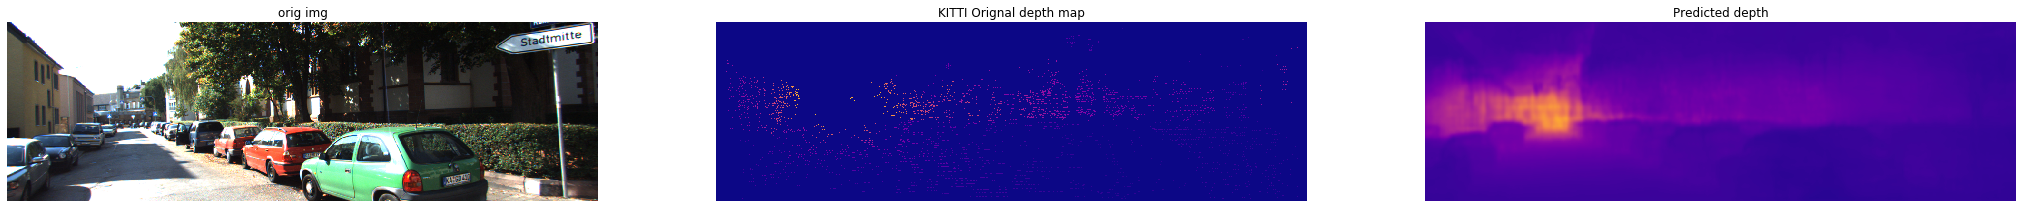

In [15]:
plt.figure(figsize=(36, 24))
plt.subplot(131)
plt.imshow(img_org)
plt.title('orig img')
plt.axis('off')
plt.subplot(132)
plt.imshow(depth_y, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('KITTI Orignal depth map')
plt.axis('off')
plt.subplot(133)
plt.imshow(depth_pca, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('Predicted depth')
plt.axis('off');